# RewP/FRN and P300 dissociation

Import packages

In [75]:
import io
import os
import mne
import copy
import glob
import array
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import scipy.io as sio
import plotly.express as px
import matplotlib.pyplot as plt


from itertools import chain
from sklearn.svm import SVC
from scipy.io import loadmat
from sklearn import set_config

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import permutation_test_score
from autoreject import AutoReject
import re



import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

Constatnts

In [2]:
random_state = 42
signal_frequency = 256

## Load EEG data

In [3]:
def create_df_data(
    dir_path,
    info_filename=None,
    info="all",
    personal=True,
    task = 'FLA',
    reject_by_annotation=True
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    header_files_glob = os.path.join(os.path.abspath(""), dir_path + "*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file, task=task, reject_by_annotation=reject_by_annotation)

        # and compute participant's id from file_name
        participant_id = re.match(r".*-(\d+)_.*", file).group(1)
        
        f_bad = participant_epochs["f_bad"].get_data()
        f_good = participant_epochs["f_good"].get_data()

        # exclude those participants who have too few samples
        if len(f_bad) < 5 or len(f_good) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [4]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename, dtype={'Demo_kod': object})
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info)
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )
        
    epoch_df = pd.DataFrame({"id": [id], "epochs": [participant_epochs]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [5]:
def get_merged_events(raw, task):
    merged_events = None
    merged_event_dict = None
    
    if task == 'MID':
        event_dict = {
            'Stimulus/F_BAD____*ex*incentive*FB': 10001,
            'Stimulus/F_GOOD___*ex*incentive*FG': 10002,
        }

        # Map for merged correct/error response markers
        merged_event_dict = {"f_good": 0, "f_bad": 1}

        # Reconstruct the original events from Raw object
        events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

        # Merge correct/error response events
        merged_events = mne.merge_events(
            events,
            [10002],
            merged_event_dict["f_good"],
            replace_events=True,
        )

        merged_events = mne.merge_events(
            merged_events,
            [10001],
            merged_event_dict["f_bad"],
            replace_events=True,
        )
    elif task == 'GNG':
        event_dict = {
            'Stimulus/FB*ex*1_n*1_c_1*R': 10001,
            'Stimulus/FB*ex*2_n*2_c_1*R': 10002,
            'Stimulus/FG*ex*1_n*1_c_1*R': 10003,
            'Stimulus/FG*ex*2_n*2_c_1*R': 10004,
        }

        # Map for merged correct/error response markers
        merged_event_dict = {"f_good": 0, "f_bad": 1}

        # Reconstruct the original events from Raw object
        events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

        # Merge correct/error response events
        merged_events = mne.merge_events(
            events,
            [10003, 10004],
            merged_event_dict["f_good"],
            replace_events=True,
        )

        merged_events = mne.merge_events(
            merged_events,
            [10001, 10002],
            merged_event_dict["f_bad"],
            replace_events=True,
        )
        
    elif task == 'FLA':
        event_dict = {
            'Stimulus/F_BAD___*ex**lll*l*FB': 10001,
            'Stimulus/F_BAD___*ex**lrl*r*FB': 10002,
            'Stimulus/F_BAD___*ex**rlr*l*FB': 10003,
            'Stimulus/F_BAD___*ex**rrr*r*FB': 10004,
            'Stimulus/F_GOOD__*ex**lll*l*FG': 10005,
            'Stimulus/F_GOOD__*ex**lrl*r*FG': 10006,
            'Stimulus/F_GOOD__*ex**rlr*l*FG': 10007,
            'Stimulus/F_GOOD__*ex**rrr*r*FG': 10008,
        }

        # Map for merged correct/error response markers
        merged_event_dict = {"f_good": 0, "f_bad": 1}

        # Reconstruct the original events from Raw object
        events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

        # Merge correct/error response events
        merged_events = mne.merge_events(
            events,
            [10005, 10006, 10007, 10008],
            merged_event_dict["f_good"],
            replace_events=True,
        )

        merged_events = mne.merge_events(
            merged_events,
            [10001, 10002, 10003, 10004],
            merged_event_dict["f_bad"],
            replace_events=True,
        )
    return merged_events, merged_event_dict      

In [6]:
def load_epochs_from_file(file, task, reject_by_annotation=True, mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file, eog=('HEOG', 'VEOG'))

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only GNG
    merged_events, merged_event_dict = get_merged_events(raw, task)
    
    tmin=None
    tmax=None
    
    if task == 'FLA' or task == 'GNG':
        tmin, tmax = -0.25, 0.7  # Start and end of the segments
    elif task == 'MID':
        tmin, tmax = -0.2, 0.8  # Start and end of the segments

    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=reject_by_annotation,
        preload=True,
        verbose=0,
    )
    
    if not reject_by_annotation:
        ar = AutoReject(random_state=random_state, n_jobs=8, verbose=0)
        epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)
        epochs = epochs_ar

    return epochs

Choose the data to load

In [7]:
load_autoreject_data = False
task = 'FLA'

In [9]:
# %%capture
info_filename = 'data/sonata_data/questionnaires.csv'

if load_autoreject_data:
    df_name = f'sonata_data_{task}_autoreject_freq'
    dir_name = f'data/sonata_data/feedback_export_{task}/'
    pickled_data_filename = 'data/sonata_data/' + df_name + '.pkl'

    if os.path.isfile(pickled_data_filename):
        print("Pickled file found. Loading pickled data...")
        data_df = pd.read_pickle(pickled_data_filename)
        data_df.name = df_name
        print("Done")
        pass
    else:
        print("Pickled file not found. Loading data...")
        data_df = create_df_data(
            dir_path=dir_name, 
            info="all", 
            personal=False, 
            info_filename=info_filename, 
            task=task,
            reject_by_annotation = False
        )
        
        data_df.name = df_name
        # save loaded data into a pickle file
        data_df.to_pickle("data/sonata_data/" + data_df.name + ".pkl")
        print("Done. Pickle file created")
else:
    
    df_name = f'sonata_data_{task}_freq'
    dir_name = f'data/sonata_data/feedback_export_{task}/'
    pickled_data_filename = 'data/sonata_data/' + df_name + '.pkl'

    if os.path.isfile(pickled_data_filename):
        print("Pickled file found. Loading pickled data...")
        data_df = pd.read_pickle(pickled_data_filename)
        data_df.name = df_name
        print("Done")
        pass
    else:
        print("Pickled file not found. Loading data...")
        data_df = create_df_data(
            dir_path=dir_name, 
            info="all", 
            personal=False, 
            info_filename=info_filename, 
            task=task,
            reject_by_annotation = True
        )
        data_df.name = df_name
        # save loaded data into a pickle file
        data_df.to_pickle("data/sonata_data/" + data_df.name + ".pkl")
        print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


Loaded Sonata Flanker data

**Plan**:
- get positive and negative feedback on FCz in time window scores;
- get RewP/FRN scores
- get P300 on positive and negative feedback on FCz in P300 time window scores;
- get P300 on difference wave scores;
- get positive and negative feedback on FCz in 0.25 - 0.35 time window scores;
- get RewP/FRN scores in time window 0.25 - 0.35

In [10]:
data_df

,id,epochs,Demo_kod,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,delta,theta
0,000,"<Epochs | 228 events (all good), -0.25 - 0.69...",000,6.0,0.17,0.67,0.83,0.50,40.0,"<Epochs | 228 events (all good), -0.25 - 0.69...","<Epochs | 228 events (all good), -0.25 - 0.69..."
1,001,"<Epochs | 84 events (all good), -0.25 - 0.699...",001,17.0,0.67,1.00,1.67,0.83,52.0,"<Epochs | 84 events (all good), -0.25 - 0.699...","<Epochs | 84 events (all good), -0.25 - 0.699..."
2,002,"<Epochs | 26 events (all good), -0.25 - 0.699...",002,4.0,0.33,0.33,0.67,0.00,50.0,"<Epochs | 26 events (all good), -0.25 - 0.699...","<Epochs | 26 events (all good), -0.25 - 0.699..."
3,003,"<Epochs | 135 events (all good), -0.25 - 0.69...",003,1.0,0.00,0.00,0.00,0.17,32.0,"<Epochs | 135 events (all good), -0.25 - 0.69...","<Epochs | 135 events (all good), -0.25 - 0.69..."
4,004,"<Epochs | 20 events (all good), -0.25 - 0.699...",004,5.0,0.33,0.33,0.67,0.00,46.0,"<Epochs | 20 events (all good), -0.25 - 0.699...","<Epochs | 20 events (all good), -0.25 - 0.699..."
...,...,...,...,...,...,...,...,...,...,...,...
200,218,"<Epochs | 19 events (all good), -0.25 - 0.699...",218,10.0,0.67,0.67,1.33,0.17,45.0,"<Epochs | 19 events (all good), -0.25 - 0.699...","<Epochs | 19 events (all good), -0.25 - 0.699..."
201,219,"<Epochs | 253 events (all good), -0.25 - 0.69...",219,8.0,0.33,0.67,1.00,0.33,45.0,"<Epochs | 253 events (all good), -0.25 - 0.69...","<Epochs | 253 events (all good), -0.25 - 0.69..."
202,220,"<Epochs | 104 events (all good), -0.25 - 0.69...",220,7.0,0.33,0.33,0.67,0.33,38.0,"<Epochs | 104 events (all good), -0.25 - 0.69...","<Epochs | 104 events (all good), -0.25 - 0.69..."
203,223,"<Epochs | 187 events (all good), -0.25 - 0.69...",223,0.0,0.00,0.00,0.00,0.00,31.0,"<Epochs | 187 events (all good), -0.25 - 0.69...","<Epochs | 187 events (all good), -0.25 - 0.69..."


## 1) positive, negative feedback and diff (RewP/FRN) scores on FCz in 0.2 - 0.3 s time window

In [49]:
tmin = 0.2
tmax = 0.3
picks = ['FCz']

In [50]:
data_df['positive_feedback_score'] = data_df['epochs'].apply(lambda x: np.mean(x['f_good'].average().get_data(tmin=tmin, tmax=tmax, picks=picks), axis=-1)[0])
data_df['negative_feedback_score'] = data_df['epochs'].apply(lambda x: np.mean(x['f_bad'].average().get_data(tmin=tmin, tmax=tmax, picks=picks), axis=-1)[0])
data_df['RewP_score'] = data_df['epochs'].apply(lambda x: np.mean((x['f_good'].average().get_data(tmin=tmin, tmax=tmax, picks=picks)) - (x['f_bad'].average().get_data(tmin=tmin, tmax=tmax, picks=picks)), axis=-1)[0])

In [51]:
data_df.head()

,id,epochs,Demo_kod,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,delta,theta,positive_feedback_score,negative_feedback_score,RewP_score,positive_feedback_25_score,negative_feedback_25_score,RewP_25_score,positive_feedback_P3_score,negative_feedback_P3_score,diff_wave_P3_score
0,000,"<Epochs | 228 events (all good), -0.25 - 0.69...",000,6.0,0.17,0.67,0.83,0.50,40.0,"<Epochs | 228 events (all good), -0.25 - 0.69...","<Epochs | 228 events (all good), -0.25 - 0.69...",-0.000001,-0.000001,-1.234423e-07,[1.2840957692307692e-06],[3.3314387096774206e-07],[9.509518982630272e-07],[1.7394803113553113e-06],[-3.713421658986174e-07],[1.7548897451803777e-06]
1,001,"<Epochs | 84 events (all good), -0.25 - 0.699...",001,17.0,0.67,1.00,1.67,0.83,52.0,"<Epochs | 84 events (all good), -0.25 - 0.699...","<Epochs | 84 events (all good), -0.25 - 0.699...",0.000011,0.000006,5.178871e-06,[1.4048125853658538e-05],[1.0009872558139534e-05],[4.038253295519001e-06],[1.4141026713124272e-05],[1.1804099667774087e-05],[7.996101487848506e-07]
2,002,"<Epochs | 26 events (all good), -0.25 - 0.699...",002,4.0,0.33,0.33,0.67,0.00,50.0,"<Epochs | 26 events (all good), -0.25 - 0.699...","<Epochs | 26 events (all good), -0.25 - 0.699...",0.000002,-0.000002,3.455908e-06,[1.4995446153846156e-06],[-5.7224984615384615e-06],[7.222043076923077e-06],[5.9728278388278385e-06],[-2.8669230769230765e-06],[9.371115384615385e-06]
3,003,"<Epochs | 135 events (all good), -0.25 - 0.69...",003,1.0,0.00,0.00,0.00,0.17,32.0,"<Epochs | 135 events (all good), -0.25 - 0.69...","<Epochs | 135 events (all good), -0.25 - 0.69...",0.000011,0.000008,3.060973e-06,[1.3461092549019608e-05],[1.054150380952381e-05],[2.9195887394957983e-06],[1.3316099906629316e-05],[1.4042681972789115e-05],[-7.541434766214181e-07]
4,004,"<Epochs | 20 events (all good), -0.25 - 0.699...",004,5.0,0.33,0.33,0.67,0.00,46.0,"<Epochs | 20 events (all good), -0.25 - 0.699...","<Epochs | 20 events (all good), -0.25 - 0.699...",0.000009,0.000008,1.542753e-06,[1.1055119999999998e-05],[1.0007449230769231e-05],[1.0476707692307694e-06],[1.1583523809523809e-05],[1.5186941391941393e-05],[-2.3168072696534237e-06]


## 2)  positive, negative feedback and diff (RewP/FRN) scores on FCz in 0.25 - 0.35 s time window

In [53]:
tmin = 0.25
tmax = 0.35
picks = ['FCz']

In [54]:
data_df['positive_feedback_25_score'] = data_df['epochs'].apply(lambda x: np.mean(x['f_good'].average().get_data(tmin=tmin, tmax=tmax, picks=picks), axis=-1)[0])
data_df['negative_feedback_25_score'] = data_df['epochs'].apply(lambda x: np.mean(x['f_bad'].average().get_data(tmin=tmin, tmax=tmax, picks=picks), axis=-1)[0])
data_df['RewP_25_score'] = data_df['epochs'].apply(lambda x: np.mean((x['f_good'].average().get_data(tmin=tmin, tmax=tmax, picks=picks)) - (x['f_bad'].average().get_data(tmin=tmin, tmax=tmax, picks=picks)), axis=-1)[0])

In [55]:
data_df.head()

,id,epochs,Demo_kod,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,delta,theta,positive_feedback_score,negative_feedback_score,RewP_score,positive_feedback_25_score,negative_feedback_25_score,RewP_25_score,positive_feedback_P3_score,negative_feedback_P3_score,diff_wave_P3_score
0,000,"<Epochs | 228 events (all good), -0.25 - 0.69...",000,6.0,0.17,0.67,0.83,0.50,40.0,"<Epochs | 228 events (all good), -0.25 - 0.69...","<Epochs | 228 events (all good), -0.25 - 0.69...",-0.000001,-0.000001,-1.234423e-07,0.000001,3.331439e-07,9.509519e-07,[1.7394803113553113e-06],[-3.713421658986174e-07],[1.7548897451803777e-06]
1,001,"<Epochs | 84 events (all good), -0.25 - 0.699...",001,17.0,0.67,1.00,1.67,0.83,52.0,"<Epochs | 84 events (all good), -0.25 - 0.699...","<Epochs | 84 events (all good), -0.25 - 0.699...",0.000011,0.000006,5.178871e-06,0.000014,1.000987e-05,4.038253e-06,[1.4141026713124272e-05],[1.1804099667774087e-05],[7.996101487848506e-07]
2,002,"<Epochs | 26 events (all good), -0.25 - 0.699...",002,4.0,0.33,0.33,0.67,0.00,50.0,"<Epochs | 26 events (all good), -0.25 - 0.699...","<Epochs | 26 events (all good), -0.25 - 0.699...",0.000002,-0.000002,3.455908e-06,0.000001,-5.722498e-06,7.222043e-06,[5.9728278388278385e-06],[-2.8669230769230765e-06],[9.371115384615385e-06]
3,003,"<Epochs | 135 events (all good), -0.25 - 0.69...",003,1.0,0.00,0.00,0.00,0.17,32.0,"<Epochs | 135 events (all good), -0.25 - 0.69...","<Epochs | 135 events (all good), -0.25 - 0.69...",0.000011,0.000008,3.060973e-06,0.000013,1.054150e-05,2.919589e-06,[1.3316099906629316e-05],[1.4042681972789115e-05],[-7.541434766214181e-07]
4,004,"<Epochs | 20 events (all good), -0.25 - 0.699...",004,5.0,0.33,0.33,0.67,0.00,46.0,"<Epochs | 20 events (all good), -0.25 - 0.699...","<Epochs | 20 events (all good), -0.25 - 0.699...",0.000009,0.000008,1.542753e-06,0.000011,1.000745e-05,1.047671e-06,[1.1583523809523809e-05],[1.5186941391941393e-05],[-2.3168072696534237e-06]


## 3) positive, negative feedback and diff scores on FCz in P300 time window

In [56]:
tmin = 0.3
tmax = 0.38
picks = ['FCz']

In [57]:
data_df['positive_feedback_P3_score'] = data_df['epochs'].apply(lambda x: np.mean(x['f_good'].average().get_data(tmin=tmin, tmax=tmax, picks=picks), axis=-1)[0])

In [58]:
tmin = 0.32
tmax = 0.4
picks = ['FCz']

In [59]:
data_df['negative_feedback_P3_score'] = data_df['epochs'].apply(lambda x: np.mean(x['f_bad'].average().get_data(tmin=tmin, tmax=tmax, picks=picks), axis=-1)[0])

In [60]:
tmin = 0.3
tmax = 0.4
picks = ['FCz']

In [61]:
data_df['diff_wave_P3_score'] = data_df['epochs'].apply(lambda x: np.mean((x['f_good'].average().get_data(tmin=tmin, tmax=tmax, picks=picks)) - (x['f_bad'].average().get_data(tmin=tmin, tmax=tmax, picks=picks)), axis=-1)[0])

In [62]:
data_df.head()

,id,epochs,Demo_kod,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,delta,theta,positive_feedback_score,negative_feedback_score,RewP_score,positive_feedback_25_score,negative_feedback_25_score,RewP_25_score,positive_feedback_P3_score,negative_feedback_P3_score,diff_wave_P3_score
0,000,"<Epochs | 228 events (all good), -0.25 - 0.69...",000,6.0,0.17,0.67,0.83,0.50,40.0,"<Epochs | 228 events (all good), -0.25 - 0.69...","<Epochs | 228 events (all good), -0.25 - 0.69...",-0.000001,-0.000001,-1.234423e-07,0.000001,3.331439e-07,9.509519e-07,0.000002,-3.713422e-07,1.754890e-06
1,001,"<Epochs | 84 events (all good), -0.25 - 0.699...",001,17.0,0.67,1.00,1.67,0.83,52.0,"<Epochs | 84 events (all good), -0.25 - 0.699...","<Epochs | 84 events (all good), -0.25 - 0.699...",0.000011,0.000006,5.178871e-06,0.000014,1.000987e-05,4.038253e-06,0.000014,1.180410e-05,7.996101e-07
2,002,"<Epochs | 26 events (all good), -0.25 - 0.699...",002,4.0,0.33,0.33,0.67,0.00,50.0,"<Epochs | 26 events (all good), -0.25 - 0.699...","<Epochs | 26 events (all good), -0.25 - 0.699...",0.000002,-0.000002,3.455908e-06,0.000001,-5.722498e-06,7.222043e-06,0.000006,-2.866923e-06,9.371115e-06
3,003,"<Epochs | 135 events (all good), -0.25 - 0.69...",003,1.0,0.00,0.00,0.00,0.17,32.0,"<Epochs | 135 events (all good), -0.25 - 0.69...","<Epochs | 135 events (all good), -0.25 - 0.69...",0.000011,0.000008,3.060973e-06,0.000013,1.054150e-05,2.919589e-06,0.000013,1.404268e-05,-7.541435e-07
4,004,"<Epochs | 20 events (all good), -0.25 - 0.699...",004,5.0,0.33,0.33,0.67,0.00,46.0,"<Epochs | 20 events (all good), -0.25 - 0.699...","<Epochs | 20 events (all good), -0.25 - 0.699...",0.000009,0.000008,1.542753e-06,0.000011,1.000745e-05,1.047671e-06,0.000012,1.518694e-05,-2.316807e-06


## Models visualizations

- positive feedback 0.2 - 0.3

<AxesSubplot: xlabel='positive_feedback_score', ylabel='STAI'>

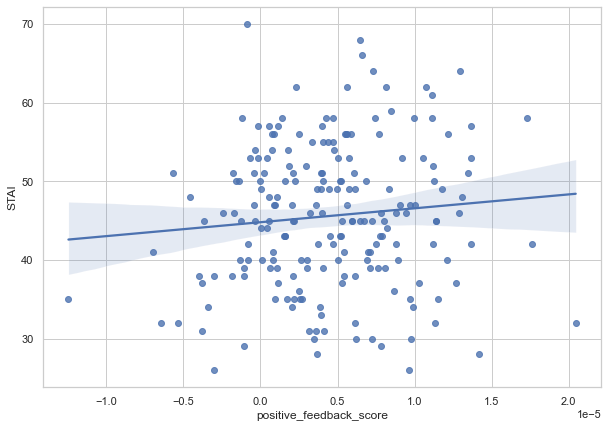

In [89]:
sns.regplot(data=data_df, x='positive_feedback_score', y='STAI')

- negative feedback 0.2 - 0.3

<AxesSubplot: xlabel='negative_feedback_score', ylabel='STAI'>

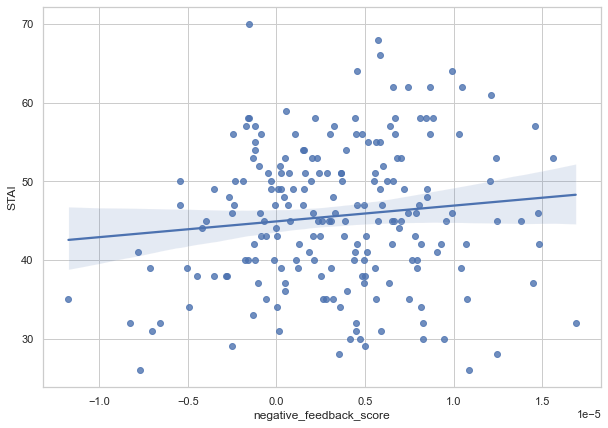

In [90]:
sns.regplot(data=data_df, x='negative_feedback_score', y='STAI')

- RewP/FRN score 0.2 - 0.3

<AxesSubplot: xlabel='RewP_score', ylabel='STAI'>

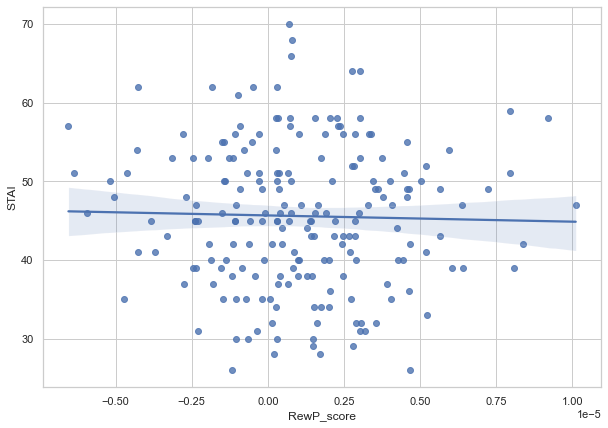

In [92]:
sns.regplot(data=data_df, x='RewP_score', y='STAI')

- positive feedback 0.25 - 0.35

<AxesSubplot: xlabel='positive_feedback_25_score', ylabel='STAI'>

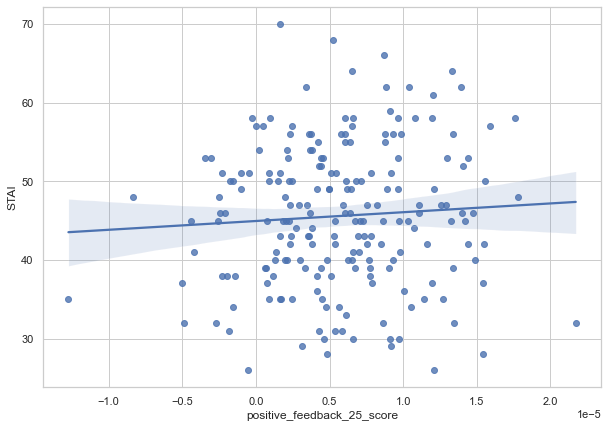

In [93]:
sns.regplot(data=data_df, x='positive_feedback_25_score', y='STAI')

- negative feedback 0.25 - 0.35

<AxesSubplot: xlabel='negative_feedback_25_score', ylabel='STAI'>

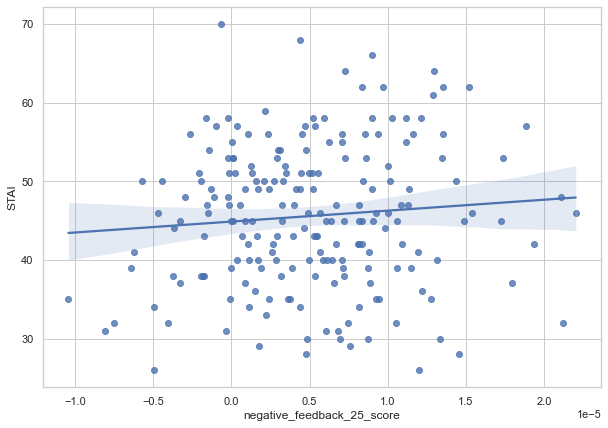

In [94]:
sns.regplot(data=data_df, x='negative_feedback_25_score', y='STAI')

- RewP/FRN score 0.25 - 0.35

<AxesSubplot: xlabel='RewP_25_score', ylabel='STAI'>

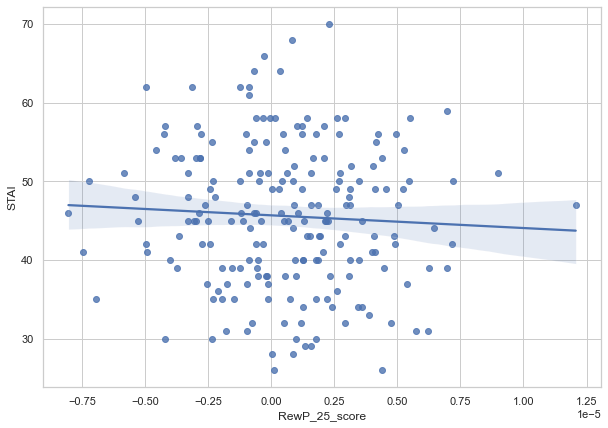

In [95]:
sns.regplot(data=data_df, x='RewP_25_score', y='STAI')

- positive feedback P300

<AxesSubplot: xlabel='positive_feedback_P3_score', ylabel='STAI'>

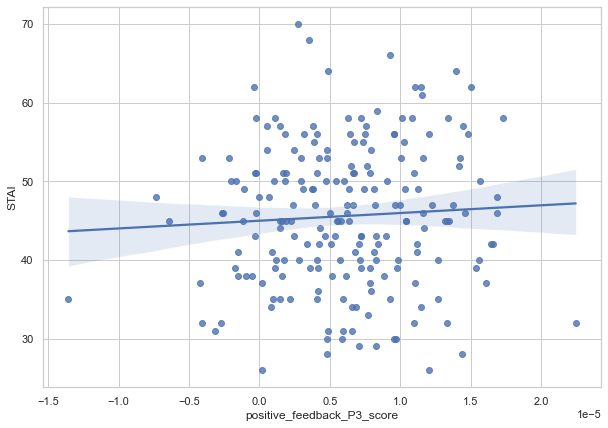

In [96]:
sns.regplot(data=data_df, x='positive_feedback_P3_score', y='STAI')

- negative feedback P300

<AxesSubplot: xlabel='negative_feedback_P3_score', ylabel='STAI'>

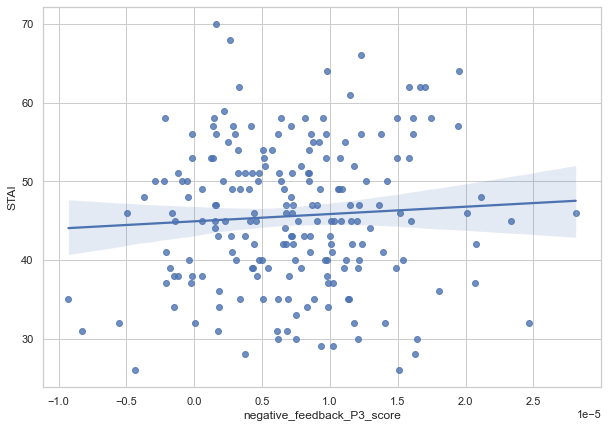

In [97]:
sns.regplot(data=data_df, x='negative_feedback_P3_score', y='STAI')

- Diff wave P300

<AxesSubplot: xlabel='diff_wave_P3_score', ylabel='STAI'>

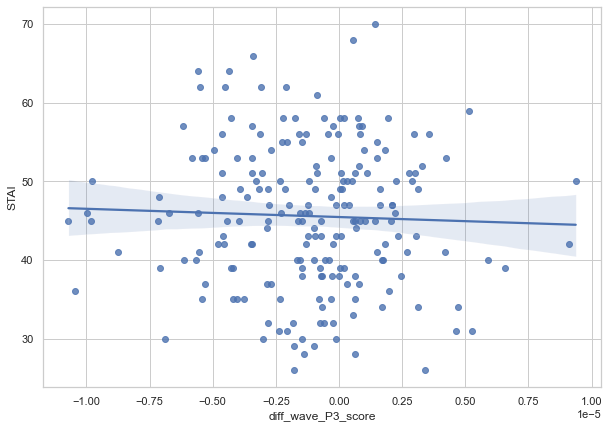

In [98]:
sns.regplot(data=data_df, x='diff_wave_P3_score', y='STAI')

- Positive feedback

<AxesSubplot: xlabel='positive_feedback_P3_score', ylabel='STAI'>

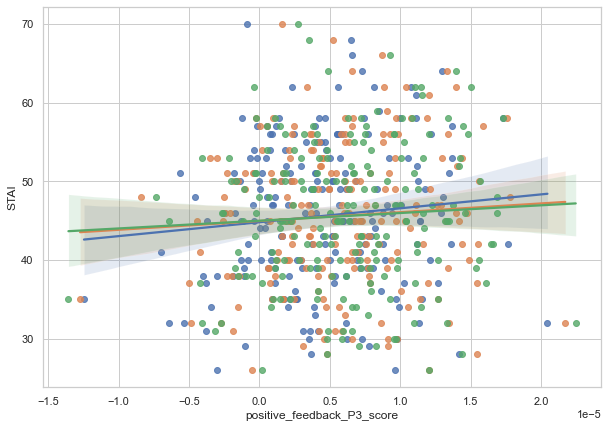

In [99]:
sns.regplot(data=data_df, x='positive_feedback_score', y='STAI')
sns.regplot(data=data_df, x='positive_feedback_25_score', y='STAI')
sns.regplot(data=data_df, x='positive_feedback_P3_score', y='STAI')

- negative feedback

<AxesSubplot: xlabel='negative_feedback_P3_score', ylabel='STAI'>

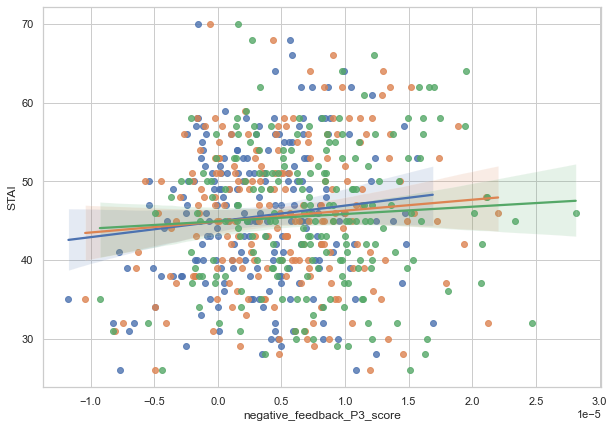

In [100]:
sns.regplot(data=data_df, x='negative_feedback_score', y='STAI')
sns.regplot(data=data_df, x='negative_feedback_25_score', y='STAI')
sns.regplot(data=data_df, x='negative_feedback_P3_score', y='STAI')

- diff

<AxesSubplot: xlabel='diff_wave_P3_score', ylabel='STAI'>

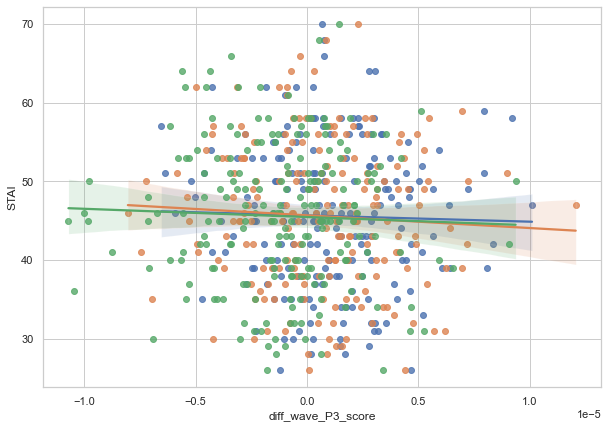

In [103]:
sns.regplot(data=data_df, x='RewP_score', y='STAI')
sns.regplot(data=data_df, x='RewP_25_score', y='STAI')
sns.regplot(data=data_df, x='diff_wave_P3_score', y='STAI')

## Statistical tests

- diff

In [112]:
RewP_scores = data_df[['RewP_score']].to_numpy().ravel()
RewP_25_scores = data_df[['RewP_25_score']].to_numpy().ravel()
diff_wave_P3_scores = data_df[['diff_wave_P3_score']].to_numpy().ravel()

    - t-values

In [107]:
t_value, p_value = ttest_rel(RewP_scores, RewP_25_scores)
print(f"t({len(RewP_25_scores) -1}) = {t_value}, p = {p_value}")

t(204) = 4.377352677052969, p = 1.9175351615962168e-05


In [108]:
t_value, p_value = ttest_rel(RewP_scores, diff_wave_P3_scores)
print(f"t({len(RewP_25_scores) -1}) = {t_value}, p = {p_value}")

t(204) = 11.317239855485115, p = 2.3211760550652577e-23


In [109]:
t_value, p_value = ttest_rel(RewP_25_scores, diff_wave_P3_scores)
print(f"t({len(RewP_25_scores) -1}) = {t_value}, p = {p_value}")

t(204) = 13.298120362921862, p = 1.808465596577751e-29


        - r

In [113]:
r, p_value = pearsonr(RewP_scores, RewP_25_scores)
print(f"r = {r}, p = {p_value}")

r = 0.8800508530551288, p = 1.4091619034533749e-67


In [114]:
r, p_value = pearsonr(RewP_scores, diff_wave_P3_scores)
print(f"r = {r}, p = {p_value}")

r = 0.6047880522433097, p = 7.773216657895493e-22


In [115]:
r, p_value = pearsonr(RewP_25_scores, diff_wave_P3_scores)
print(f"r = {r}, p = {p_value}")

r = 0.8347595051435784, p = 1.6492468062119357e-54


- positive

In [117]:
RewP_scores = data_df[['positive_feedback_score']].to_numpy().ravel()
RewP_25_scores = data_df[['positive_feedback_25_score']].to_numpy().ravel()
diff_wave_P3_scores = data_df[['positive_feedback_P3_score']].to_numpy().ravel()

    - t-value

In [118]:
t_value, p_value = ttest_rel(RewP_scores, RewP_25_scores)
print(f"t({len(RewP_25_scores) -1}) = {t_value}, p = {p_value}")

t(204) = -9.680303973204856, p = 1.7730744494060765e-18


In [119]:
t_value, p_value = ttest_rel(RewP_scores, diff_wave_P3_scores)
print(f"t({len(RewP_25_scores) -1}) = {t_value}, p = {p_value}")

t(204) = -8.560187785311413, p = 2.722548387151514e-15


In [120]:
t_value, p_value = ttest_rel(RewP_25_scores, diff_wave_P3_scores)
print(f"t({len(RewP_25_scores) -1}) = {t_value}, p = {p_value}")

t(204) = -4.06860538632446, p = 6.757811141372245e-05


        - r

In [121]:
r, p_value = pearsonr(RewP_scores, RewP_25_scores)
print(f"r = {r}, p = {p_value}")

r = 0.9424430570636806, p = 1.550266475894026e-98


In [122]:
r, p_value = pearsonr(RewP_scores, diff_wave_P3_scores)
print(f"r = {r}, p = {p_value}")

r = 0.8674138218328734, p = 1.8759739819923883e-63


In [123]:
r, p_value = pearsonr(RewP_25_scores, diff_wave_P3_scores)
print(f"r = {r}, p = {p_value}")

r = 0.9621902161831358, p = 1.2713777991113424e-116


- negative

In [124]:
RewP_scores = data_df[['negative_feedback_score']].to_numpy().ravel()
RewP_25_scores = data_df[['negative_feedback_25_score']].to_numpy().ravel()
diff_wave_P3_scores = data_df[['negative_feedback_P3_score']].to_numpy().ravel()

    - t-value

In [125]:
t_value, p_value = ttest_rel(RewP_scores, RewP_25_scores)
print(f"t({len(RewP_25_scores) -1}) = {t_value}, p = {p_value}")

t(204) = -10.576601653951027, p = 3.994168235824746e-21


In [126]:
t_value, p_value = ttest_rel(RewP_scores, diff_wave_P3_scores)
print(f"t({len(RewP_25_scores) -1}) = {t_value}, p = {p_value}")

t(204) = -15.904809677184307, p = 1.4051895120986186e-37


In [127]:
t_value, p_value = ttest_rel(RewP_25_scores, diff_wave_P3_scores)
print(f"t({len(RewP_25_scores) -1}) = {t_value}, p = {p_value}")

t(204) = -13.777071433732745, p = 5.836187167848263e-31


        - r

In [128]:
r, p_value = pearsonr(RewP_scores, RewP_25_scores)
print(f"r = {r}, p = {p_value}")

r = 0.9251358348005794, p = 2.4702172568629863e-87


In [129]:
r, p_value = pearsonr(RewP_scores, diff_wave_P3_scores)
print(f"r = {r}, p = {p_value}")

r = 0.8331609972176032, p = 4.018522880390574e-54


In [130]:
r, p_value = pearsonr(RewP_25_scores, diff_wave_P3_scores)
print(f"r = {r}, p = {p_value}")

r = 0.9331947494441287, p = 3.569612000636746e-92
